In [1]:
#!nvidia-smi

In [2]:
#!pip show requests pandas matplotlib seaborn sklearn tensorflow numpy
#!pip install sklearn numpy==1.21.6 pandas==1.3.5 matplotlib==3.2.2 requests==2.23.0 spyder==5.1.5 install seaborn==0.11.2

In [3]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
import datetime
import numpy as np

In [4]:
data_columns = {
    'market': 'Market',
    'candle_date_time_utc': 'Date',
    'opening_price': 'Open',
    'high_price': 'High',
    'low_price': 'Low',
    'trade_price': 'Close',
    'candle_acc_trade_volume': 'Volume',
    'candle_acc_trade_price' : 'Price',
}

# str UTC DATETIME
def get_query_datetime():
    now = datetime.datetime.now() #- datetime.timedelta(hours=9)
    now = str(now.strftime('%Y-%m-%d %H:%M:%S'))
    now = now.replace(' ', 'T') + 'Z'
    return now


# 크롤링한 데이터 전처리
def preprocessing_crawled_data(datas: str):
    array_dict_datas = []
    array_datas = datas.split('},')

    for data in array_datas:
        array_data = []
        data = data.replace('{', '')
        data = data.replace('}', '')
        array_data = data.split(',')

        dict_data = {}
        for value in array_data:
            tmp = value.split(':', 1)
            if tmp[0][1: -1] in data_columns:
                dict_data[data_columns[tmp[0][1: -1]]] = tmp[1]

        if dict_data != {}:
            dict_data['Market'] = dict_data['Market'][1: -1]
            dict_data['Date'] = dict_data['Date'][1: -1]
            dict_data['Open'] = float(dict_data['Open'])
            dict_data['High'] = float(dict_data['High'])
            dict_data['Low'] = float(dict_data['Low'])
            dict_data['Close'] = float(dict_data['Close'])
            dict_data['Volume'] = float(dict_data['Volume'])
            dict_data['Price'] = float(dict_data['Price'])
            array_dict_datas.append(dict_data)

    return array_dict_datas


# 크롤링 후 df 리턴
def do_crawl(unit: str, market: str, time: str, count: str, loop: int):
    df = pd.DataFrame([], columns=['Date', 'Market', 'Open', 'High', 'Low', 'Close', 'Volume', 'Price'])
    url = "https://api.upbit.com/v1/candles/minutes/" + unit

    for _ in range(loop):
        querystring = {"market": market, "to": time, "count": count}
        response = requests.request("GET", url, params=querystring)
        df = df.append(preprocessing_crawled_data(response.text[1:-1]), ignore_index=True)
        time = df.iloc[-1]['Date'] + 'Z'
    df = df.loc[::-1].reset_index(drop=True)
    return df
 
def do_mcrawl(unit: str, markets: list, time: str, count: str, loop: int):
    df = pd.DataFrame([], columns=['Date', 'Market', 'Open', 'High', 'Low', 'Close', 'Volume', 'Price'])
    url = "https://api.upbit.com/v1/candles/minutes/" + unit

    for market in markets:
       for _ in range(loop):
            print(market," -> ",(_+1)*int(count),"/",loop*int(count))
            querystring = {"market": market, "to": time, "count": count}
            response = requests.request("GET", url, params=querystring)
            df = df.append(preprocessing_crawled_data(response.text[1:-1]), ignore_index=True)
            time = df.iloc[-1]['Date'] + 'Z'
       df = df.loc[::-1].reset_index(drop=True)
    return df

In [5]:
# first 데이터 셋 만들기
UNIT = '1'
MARKETS = ['KRW-DOGE','KRW-BTC','KRW-ETH']
LOOP=50

df = do_mcrawl(UNIT, MARKETS, get_query_datetime(), '200', LOOP)
df.to_csv("data.csv")

print(df)

KRW-DOGE  ->  200 / 10000
KRW-DOGE  ->  400 / 10000
KRW-DOGE  ->  600 / 10000
KRW-DOGE  ->  800 / 10000
KRW-DOGE  ->  1000 / 10000
KRW-DOGE  ->  1200 / 10000
KRW-DOGE  ->  1400 / 10000
KRW-DOGE  ->  1600 / 10000
KRW-DOGE  ->  1800 / 10000
KRW-DOGE  ->  2000 / 10000
KRW-DOGE  ->  2200 / 10000
KRW-DOGE  ->  2400 / 10000
KRW-DOGE  ->  2600 / 10000
KRW-DOGE  ->  2800 / 10000
KRW-DOGE  ->  3000 / 10000
KRW-DOGE  ->  3200 / 10000
KRW-DOGE  ->  3400 / 10000
KRW-DOGE  ->  3600 / 10000
KRW-DOGE  ->  3800 / 10000
KRW-DOGE  ->  4000 / 10000
KRW-DOGE  ->  4200 / 10000
KRW-DOGE  ->  4400 / 10000
KRW-DOGE  ->  4600 / 10000
KRW-DOGE  ->  4800 / 10000
KRW-DOGE  ->  5000 / 10000
KRW-DOGE  ->  5200 / 10000
KRW-DOGE  ->  5400 / 10000
KRW-DOGE  ->  5600 / 10000
KRW-DOGE  ->  5800 / 10000
KRW-DOGE  ->  6000 / 10000
KRW-DOGE  ->  6200 / 10000
KRW-DOGE  ->  6400 / 10000
KRW-DOGE  ->  6600 / 10000
KRW-DOGE  ->  6800 / 10000
KRW-DOGE  ->  7000 / 10000
KRW-DOGE  ->  7200 / 10000
KRW-DOGE  ->  7400 / 10000
KRW-D

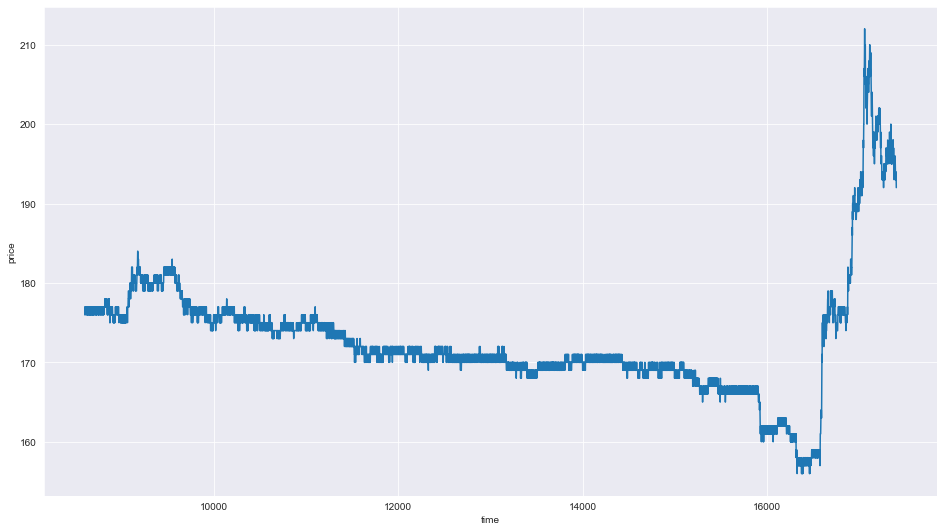

In [6]:
plt.figure(figsize=(16, 9))
sns.lineplot(y=df[df['Market'] == MARKETS[0]]['Close'], x=df[df['Market'] == MARKETS[0]].index)
plt.xlabel('time')
plt.ylabel('price')
plt.show()

In [7]:
scaler = MinMaxScaler()
# 스케일을 적용할 column을 정의합니다.
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'Price']
# 스케일 후 columns
scaled = scaler.fit_transform(df[scale_cols])

df = pd.DataFrame(scaled, columns=scale_cols)
print(df)

           Open      High       Low     Close        Volume     Price
0      0.078266  0.078180  0.078298  0.078284  5.262851e-07  0.011909
1      0.078247  0.078180  0.078279  0.078304  4.840621e-07  0.010952
2      0.078266  0.078180  0.078279  0.078304  7.397048e-07  0.016736
3      0.078266  0.078180  0.078259  0.078246  4.669987e-07  0.010567
4      0.078208  0.078180  0.078240  0.078227  1.453024e-07  0.003286
...         ...       ...       ...       ...           ...       ...
25395  0.991880  0.991850  0.992068  0.992609  6.997869e-08  0.020068
25396  0.992034  0.990945  0.992048  0.991895  8.189572e-08  0.023484
25397  0.992246  0.991504  0.992685  0.992590  6.450451e-08  0.018505
25398  0.993191  0.992120  0.992878  0.992706  1.210410e-07  0.034736
25399  0.993693  0.992833  0.993863  0.993748  2.691318e-07  0.077300

[25400 rows x 6 columns]


In [8]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.1, random_state=0, shuffle=False)
print(type(x_test))
print(x_test)
# 경고 무시 가능

<class 'pandas.core.frame.DataFrame'>
           Open      High       Low        Volume     Price
22860  0.978321  0.977786  0.978905  2.030969e-08  0.005746
22861  0.978263  0.977805  0.978905  3.909672e-08  0.011062
22862  0.978359  0.977285  0.978886  4.251751e-08  0.012026
22863  0.978436  0.977497  0.978886  3.687598e-08  0.010432
22864  0.978475  0.977497  0.979079  1.249887e-08  0.003537
...         ...       ...       ...           ...       ...
25395  0.991880  0.991850  0.992068  6.997869e-08  0.020068
25396  0.992034  0.990945  0.992048  8.189572e-08  0.023484
25397  0.992246  0.991504  0.992685  6.450451e-08  0.018505
25398  0.993191  0.992120  0.992878  1.210410e-07  0.034736
25399  0.993693  0.992833  0.993863  2.691318e-07  0.077300

[2540 rows x 5 columns]


C:\Users\franknoh\AppData\Local\Temp\3/ipykernel_6092/1088860431.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.1, random_state=0, shuffle=False)


In [9]:
def windowed_dataset(x, y, window_size, batch_size, shuffle):
    # X값 window dataset 구성
    ds_x = tf.data.Dataset.from_tensor_slices(x)
    ds_x = ds_x.window(window_size, shift=1, stride=1, drop_remainder=True)
    ds_x = ds_x.flat_map(lambda x: x.batch(window_size))
    # y값 추가
    ds_y = tf.data.Dataset.from_tensor_slices(y[window_size:])
    ds = tf.data.Dataset.zip((ds_x, ds_y))
    if shuffle:
        ds = ds.shuffle(1000)
    return ds.batch(batch_size).prefetch(1)

In [10]:
WINDOW_SIZE=5
BATCH_SIZE=32

In [11]:
train_data = windowed_dataset(x_train, y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(x_test, y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [12]:
model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 5]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])

# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [13]:
# earlystopping은 35번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=35)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)
                             
history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=1000,
                    callbacks=[checkpoint, earlystopping])

Epoch 1/1000
    713/Unknown - 6s 5ms/step - loss: 2.0910e-04 - mse: 4.1820e-04
Epoch 1: val_loss improved from inf to 0.00001, saving model to tmp\ckeckpointer.ckpt
715/715 [==============================] - 9s 8ms/step - loss: 2.0874e-04 - mse: 4.1749e-04 - val_loss: 7.1824e-06 - val_mse: 1.4365e-05
Epoch 2/1000
714/715 [============================>.] - ETA: 0s - loss: 7.0580e-05 - mse: 1.4116e-04
Epoch 2: val_loss improved from 0.00001 to 0.00001, saving model to tmp\ckeckpointer.ckpt
715/715 [==============================] - 4s 5ms/step - loss: 7.0559e-05 - mse: 1.4112e-04 - val_loss: 6.9727e-06 - val_mse: 1.3945e-05
Epoch 3/1000
708/715 [============================>.] - ETA: 0s - loss: 5.3080e-05 - mse: 1.0616e-04
Epoch 3: val_loss improved from 0.00001 to 0.00001, saving model to tmp\ckeckpointer.ckpt
715/715 [==============================] - 4s 5ms/step - loss: 5.2641e-05 - mse: 1.0528e-04 - val_loss: 6.7278e-06 - val_mse: 1.3456e-05
Epoch 4/1000
707/715 [===================

In [14]:
print("%.7f" % (float(min(history.history['val_loss']))))
model.load_weights(filename)
pred = model.predict(test_data)
actual = np.asarray(y_test)[WINDOW_SIZE:]
actual = np.reshape(actual, (len(actual), 1))
print(pred.shape)
print(actual.shape)

0.0000003
(2535, 1)
(2535, 1)


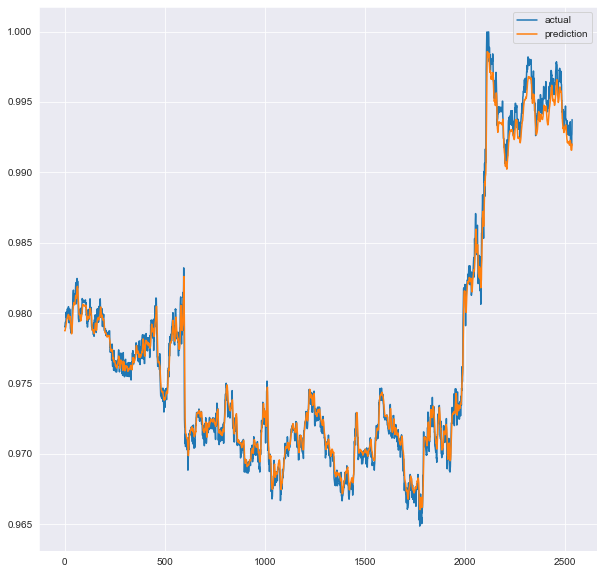

In [15]:
# 수집한 데이터 내에서 예측값과 실제값을 출력
plt.figure(figsize=(10,10))
plt.plot(actual, label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

In [16]:
live_df = do_crawl(UNIT, MARKETS[0], get_query_datetime(), '200', 50)
print(datetime.datetime.now())
print(get_query_datetime())

scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'Price']
scaled = scaler.fit_transform(live_df[scale_cols])
live_scaled_df = pd.DataFrame(scaled, columns=scale_cols)
live_x, live_y = live_scaled_df.drop('Close', 1), live_scaled_df['Close']
live_data = windowed_dataset(live_x, live_y, WINDOW_SIZE, BATCH_SIZE, False)

pred = model.predict(live_data)

# create empty table with 12 fields
trainPredict_dataset_like = np.zeros(shape=(len(pred), 6) )
# put the predicted values in the right field
trainPredict_dataset_like[:,0] = pred[:,0]
# inverse transform and then select the right field
pred = scaler.inverse_transform(trainPredict_dataset_like)[:,0]

def muzisung_buy(pred_percent: float, live_percent: float, money: float):
    global array_pred_percents
    array_pred_percents.sort()
    if pred_percent > np.mean(array_pred_percents):
        money = money + (money * live_percent / 100)
    return money

2022-04-26 10:06:24.247819
2022-04-26T10:06:24Z


C:\Users\franknoh\AppData\Local\Temp\3/ipykernel_6092/3261543731.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  live_x, live_y = live_scaled_df.drop('Close', 1), live_scaled_df['Close']


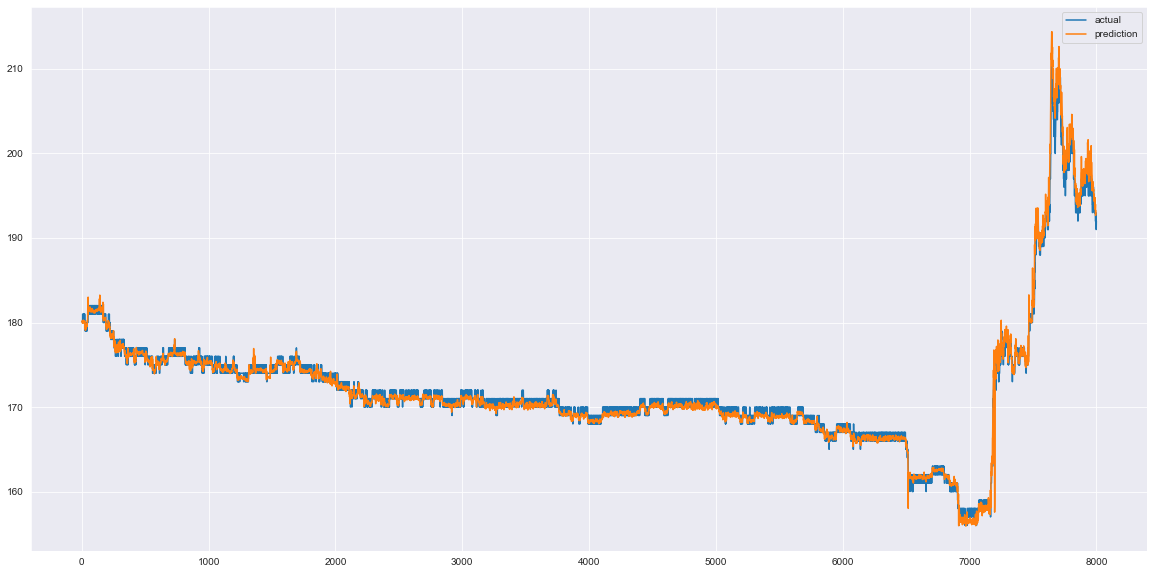

In [17]:
plt.figure(figsize=(20,10))
plt.plot(live_df['Close'][WINDOW_SIZE:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

In [18]:
cnt_minus = 0
cnt_fault = 0
cnt_total = 0
seed_money = 100000000
print(len(live_df['Close'][WINDOW_SIZE:]))
print(len(pred))
origin_money = seed_money
origin_percent = (float(live_df['Close'][len(live_df['Close'])-1]) - float(live_df['Close'][WINDOW_SIZE])) / float(live_df['Close'][WINDOW_SIZE]) * 100
array_pred_percents = []

for indx in range(len(pred)):
    live_close = float(live_df['Close'][indx+WINDOW_SIZE])
    pred_close = float(pred[indx])
    pred_percent = (pred_close - live_close) / live_close * 100
    if pred_percent > 0:
        array_pred_percents.append(pred_percent)

    print("%d - (현재)%.2f -> (10분 뒤)%.2f" % (indx, live_close, pred_close), end='')
    print(" ==> (예측)%.2f%%" % (pred_percent), end='')
    
    if indx + WINDOW_SIZE + 1 < len(live_df['Close']):
        live_percent = (float(live_df['Close'][indx+WINDOW_SIZE+1]) - live_close) / live_close * 100
        print(" | (실제)%.2f%%  | " % (live_percent), end='')
        prev_money = seed_money
        next_money = muzisung_buy(pred_percent, live_percent, seed_money)
        print("[%d] -> [%d] == (%d)" % (int(seed_money), int(next_money), int(next_money - seed_money)))
        seed_money = next_money
    else:
        print()
print("(존버시) %d" % (int(origin_money + (origin_money * origin_percent / 100))))
print("(무지성) %d" % (int(seed_money)))
print(cnt_fault)

7995
7995
0 - (현재)180.00 -> (10분 뒤)180.13 ==> (예측)0.07% | (실제)0.00%  | [100000000] -> [100000000] == (0)
1 - (현재)180.00 -> (10분 뒤)180.18 ==> (예측)0.10% | (실제)0.56%  | [100000000] -> [100555555] == (555555)
2 - (현재)181.00 -> (10분 뒤)180.15 ==> (예측)-0.47% | (실제)-0.55%  | [100555555] -> [100555555] == (0)
3 - (현재)180.00 -> (10분 뒤)180.14 ==> (예측)0.08% | (실제)0.00%  | [100555555] -> [100555555] == (0)
4 - (현재)180.00 -> (10분 뒤)180.10 ==> (예측)0.05% | (실제)0.00%  | [100555555] -> [100555555] == (0)
5 - (현재)180.00 -> (10분 뒤)179.92 ==> (예측)-0.04% | (실제)0.00%  | [100555555] -> [100555555] == (0)
6 - (현재)180.00 -> (10분 뒤)179.99 ==> (예측)-0.01% | (실제)0.00%  | [100555555] -> [100555555] == (0)
7 - (현재)180.00 -> (10분 뒤)179.99 ==> (예측)-0.01% | (실제)0.56%  | [100555555] -> [100555555] == (0)
8 - (현재)181.00 -> (10분 뒤)179.93 ==> (예측)-0.59% | (실제)-0.55%  | [100555555] -> [100555555] == (0)
9 - (현재)180.00 -> (10분 뒤)180.00 ==> (예측)-0.00% | (실제)0.56%  | [100555555] -> [100555555] == (0)
10 - (현재)181.00 -> (10분 뒤)1